<a href="https://colab.research.google.com/github/nikhilRajput-prog/Deep-Learning-Lab-File/blob/main/Deep_Learining_assignment7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import math
import random
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim

from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [7]:
MAX_LEN = 40
BATCH_SIZE = 64
EMB_SIZE = 256
NHEAD = 8
FFN_HID_DIM = 512
NUM_ENCODER_LAYERS = 3
NUM_DECODER_LAYERS = 3
DROPOUT = 0.1
EPOCHS = 40
LR = 0.0005

## Loading Dataset

In [8]:

file_path = "/content/spa.txt"

pairs = []

with open(file_path, encoding="utf-8") as f:
    for line in f:
        parts = line.strip().split("\t")
        if len(parts) >= 2:
            pairs.append((parts[0].lower(), parts[1].lower()))


pairs = pairs[:10000]

train_data, temp_data = train_test_split(pairs, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print("Train:", len(train_data))
print("Val:", len(val_data))
print("Test:", len(test_data))
print(pairs[0])
print(pairs[10])

Train: 8000
Val: 1000
Test: 1000
('go.', 've.')
('fire!', '¡disparad!')


## Tokenization

In [9]:

def tokenize(sentence):
    return sentence.split()


def build_vocab(data):
    counter = Counter()
    for src, tgt in data:
        counter.update(tokenize(src))
        counter.update(tokenize(tgt))

    vocab = {
        "<pad>": 0,
        "<sos>": 1,
        "<eos>": 2,
        "<unk>": 3
    }

    for word, _ in counter.items():
        vocab[word] = len(vocab)

    return vocab


vocab = build_vocab(train_data)
inv_vocab = {v: k for k, v in vocab.items()}

PAD_IDX = vocab["<pad>"]
SOS_IDX = vocab["<sos>"]
EOS_IDX = vocab["<eos>"]

VOCAB_SIZE = len(vocab)

print("Vocab Size:", VOCAB_SIZE)


def encode(sentence):
    tokens = tokenize(sentence)
    ids = [SOS_IDX] + [vocab.get(t, vocab["<unk>"]) for t in tokens] + [EOS_IDX]
    ids = ids[:MAX_LEN]
    ids += [PAD_IDX] * (MAX_LEN - len(ids))
    return ids


def prepare_dataset(data):
    src = []
    tgt = []

    for s, t in data:
        src.append(encode(s))
        tgt.append(encode(t))

    return torch.tensor(src), torch.tensor(tgt)


train_src, train_tgt = prepare_dataset(train_data)
val_src, val_tgt = prepare_dataset(val_data)
test_src, test_tgt = prepare_dataset(test_data)


Vocab Size: 8377


## Positional Encoding

In [10]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, max_len=5000):
        super().__init__()

        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len).unsqueeze(1)

        div_term = torch.exp(
            torch.arange(0, emb_size, 2) * (-math.log(10000.0) / emb_size)
        )

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer("pe", pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]



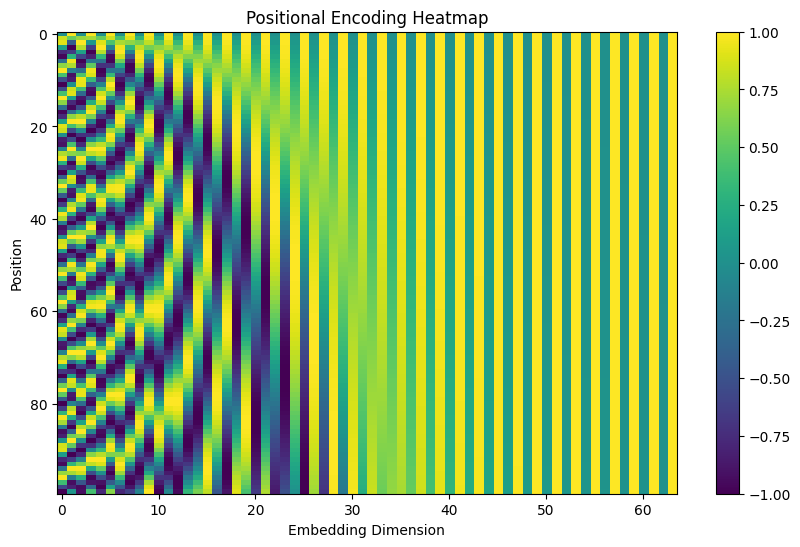

In [11]:
# ---- Generate and Plot Positional Encoding Heatmap ----

import matplotlib.pyplot as plt

emb_size = 64
max_len = 100

pe_layer = PositionalEncoding(emb_size=emb_size, max_len=max_len)

# Extract positional encoding
pe = pe_layer.pe.squeeze(0)  # shape: (max_len, emb_size)

# Plot heatmap
plt.figure(figsize=(10, 6))
plt.imshow(pe.detach().numpy(), aspect='auto')
plt.title("Positional Encoding Heatmap")
plt.xlabel("Embedding Dimension")
plt.ylabel("Position")
plt.colorbar()
plt.show()

## Transfromer Model

In [12]:
class TransformerModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.src_embed = nn.Embedding(VOCAB_SIZE, EMB_SIZE)
        self.tgt_embed = nn.Embedding(VOCAB_SIZE, EMB_SIZE)

        self.pos_encoder = PositionalEncoding(EMB_SIZE)

        self.transformer = nn.Transformer(
            d_model=EMB_SIZE,
            nhead=NHEAD,
            num_encoder_layers=NUM_ENCODER_LAYERS,
            num_decoder_layers=NUM_DECODER_LAYERS,
            dim_feedforward=FFN_HID_DIM,
            dropout=DROPOUT,
            batch_first=True
        )

        self.fc_out = nn.Linear(EMB_SIZE, VOCAB_SIZE)

    def make_src_mask(self, src):
        return (src == PAD_IDX)

    def make_tgt_mask(self, tgt):
        tgt_len = tgt.size(1)
        mask = torch.triu(torch.ones(tgt_len, tgt_len), diagonal=1).bool()
        return mask.to(device)

    def forward(self, src, tgt):

        src_mask = self.make_src_mask(src)
        tgt_mask = self.make_tgt_mask(tgt)

        src_emb = self.pos_encoder(self.src_embed(src))
        tgt_emb = self.pos_encoder(self.tgt_embed(tgt))

        output = self.transformer(
            src_emb,
            tgt_emb,
            src_key_padding_mask=src_mask,
            tgt_mask=tgt_mask,
            tgt_key_padding_mask=(tgt == PAD_IDX)
        )

        return self.fc_out(output)


model = TransformerModel().to(device)

criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
optimizer = optim.Adam(model.parameters(), lr=LR)



In [13]:
print("\nModel Architecture:\n")
print(model)

# -------------------------------
# 2️⃣ Count Trainable Parameters
# -------------------------------
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("\nTotal Trainable Parameters:", total_params)


Model Architecture:

TransformerModel(
  (src_embed): Embedding(8377, 256)
  (tgt_embed): Embedding(8377, 256)
  (pos_encoder): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-2): 3 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
          )
          (linear1): Linear(in_features=256, out_features=512, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (linear2): Linear(in_features=512, out_features=256, bias=True)
          (norm1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.1, inplace=False)
          (dropout2): Dropout(p=0.1, inplace=False)
        )
      )
      (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (decoder): 

## Training Function

In [14]:
def train_epoch(src_data, tgt_data):

    model.train()
    total_loss = 0

    for i in range(0, len(src_data), BATCH_SIZE):

        src = src_data[i:i+BATCH_SIZE].to(device)
        tgt = tgt_data[i:i+BATCH_SIZE].to(device)

        tgt_input = tgt[:, :-1]
        tgt_output = tgt[:, 1:]

        optimizer.zero_grad()

        preds = model(src, tgt_input)

        preds = preds.reshape(-1, VOCAB_SIZE)
        tgt_output = tgt_output.reshape(-1)

        loss = criterion(preds, tgt_output)
        loss.backward()

        optimizer.step()

        total_loss += loss.item()

    return total_loss / (len(src_data) // BATCH_SIZE)


## Evaluation Functions

In [15]:

def translate(sentence):

    model.eval()

    src = torch.tensor([encode(sentence)]).to(device)

    tgt = torch.tensor([[SOS_IDX]]).to(device)

    for _ in range(MAX_LEN):

        out = model(src, tgt)
        next_word = out[:, -1].argmax(-1).item()

        tgt = torch.cat(
            [tgt, torch.tensor([[next_word]]).to(device)], dim=1
        )

        if next_word == EOS_IDX:
            break

    tokens = [inv_vocab[i] for i in tgt[0].cpu().numpy()]
    return tokens



smooth = SmoothingFunction().method1

def compute_bleu(data):

    scores = []

    for src, tgt in random.sample(data, min(200, len(data))):

        pred_tokens = translate(src)
        ref_tokens = tokenize(tgt)

        score = sentence_bleu(
            [ref_tokens],
            pred_tokens,
            smoothing_function=smooth
        )

        scores.append(score)

    return np.mean(scores)



## Training Loop

In [16]:
train_losses = []
val_losses = []
bleu_scores = []

start_time = time.time()

for epoch in range(EPOCHS):

    train_loss = train_epoch(train_src, train_tgt)
    train_losses.append(train_loss)

    bleu = compute_bleu(val_data)
    bleu_scores.append(bleu)

    print(f"Epoch {epoch+1}")
    print("Train Loss:", train_loss)
    print("BLEU:", bleu)

training_time = time.time() - start_time



Epoch 1
Train Loss: 5.6511538772583005
BLEU: 0.022633428616136465
Epoch 2
Train Loss: 4.301425762176514
BLEU: 0.03226660862795877
Epoch 3
Train Loss: 3.655342956542969
BLEU: 0.04060633682760274
Epoch 4
Train Loss: 3.157015308380127
BLEU: 0.042731338565101036
Epoch 5
Train Loss: 2.7421187744140627
BLEU: 0.04006631383331109
Epoch 6
Train Loss: 2.380832872390747
BLEU: 0.046242092716523776
Epoch 7
Train Loss: 2.0395287342071535
BLEU: 0.052849655345137504
Epoch 8
Train Loss: 1.732662094116211
BLEU: 0.0650864511275544
Epoch 9
Train Loss: 1.453432144165039
BLEU: 0.053097200644301214
Epoch 10
Train Loss: 1.211320571899414
BLEU: 0.06382979165156388
Epoch 11
Train Loss: 1.015303291797638
BLEU: 0.0717805234925005
Epoch 12
Train Loss: 0.8643127255439759
BLEU: 0.060037656168277456
Epoch 13
Train Loss: 0.7340947442054748
BLEU: 0.061540418079225355
Epoch 14
Train Loss: 0.6260033781528473
BLEU: 0.06781808096340372
Epoch 15
Train Loss: 0.5501815006732941
BLEU: 0.0721528404809564
Epoch 16
Train Loss: 0.

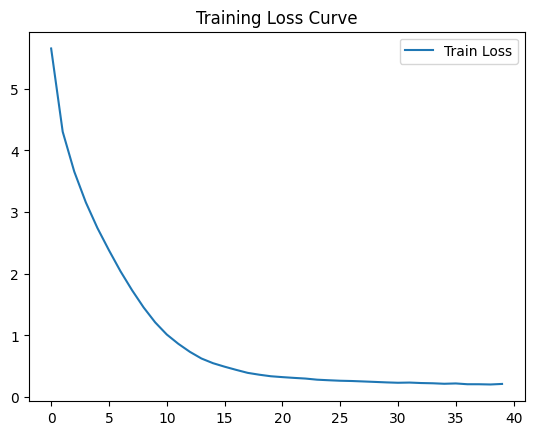

In [17]:

plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()




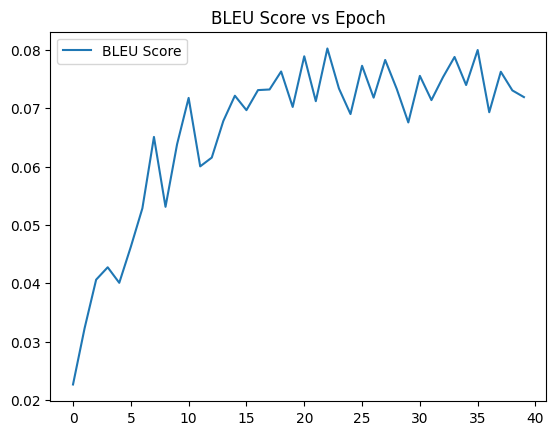

In [18]:
plt.figure()
plt.plot(bleu_scores, label="BLEU Score")
plt.title("BLEU Score vs Epoch")
plt.legend()
plt.show()

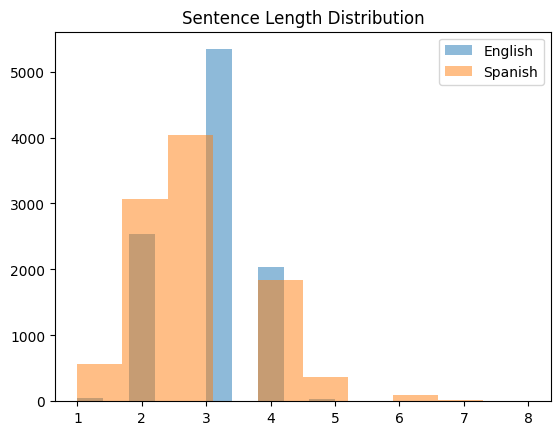

In [19]:
src_lengths = [len(tokenize(s)) for s, _ in pairs]
tgt_lengths = [len(tokenize(t)) for _, t in pairs]

plt.figure()
plt.hist(src_lengths, alpha=0.5, label="English")
plt.hist(tgt_lengths, alpha=0.5, label="Spanish")
plt.legend()
plt.title("Sentence Length Distribution")
plt.show()

## Test evaluation

In [20]:
test_bleu = compute_bleu(test_data)

print("\nFinal Test BLEU:", test_bleu)
print("Training Time (seconds):", training_time)


Final Test BLEU: 0.06811876538958056
Training Time (seconds): 526.5773220062256


## Example Translations

In [21]:
examples = random.sample(test_data, 5)

for src, tgt in examples:
    pred = translate(src)
    print("\nEN:", src)
    print("GT:", tgt)
    print("PR:", " ".join(pred))


EN: please say yes.
GT: por favor, diga que sí.
PR: <sos> por favor, digan que sí. <eos>

EN: this is hers.
GT: esto es de ella.
PR: <sos> esto es de ella. <eos>

EN: who broke this?
GT: ¿quién rompió esto?
PR: <sos> ¿quién esto? <eos>

EN: i'm not deaf.
GT: no estoy sordo.
PR: <sos> no soy sordo. <eos>

EN: we need more.
GT: necesitamos más.
PR: <sos> necesitamos más. <eos>
